In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
importlib.reload(kgs)
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()
plt.ion()

local
local
=== Running NVCC Compilation (cubin for ptxas info) ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --ptxas-options=-v -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_saved.cubin


ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 33 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    240 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 43 registers, 240 bytes cumulative stack size, 404 bytes cmem[0], 32 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_overlap_list_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_list_total
    1104 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 59 registers, 1104 bytes cumulative stack size, 396 bytes cmem[0], 24 bytes cmem[2]


In [ ]:
@dataclass
class MegaDynamics(kgs.BaseClass):
    # Configuration
    n_trees = 40
    n_ensembles = 1000
    n_rounds = 5
    seed = 42
    plot_interval = None

    # Hyperparameters
    size_setup = 0.5 # will be mulitiplied by sqrt(n_trees)
    duration_init = 10.
    duration_compact = 200.
    duration_final = 10. # careful - lowering this can seem to make things better, but actually can mean overlapping solutions
    dt = 0.02
    scaling_area_start = 0.3
    scaling_area_end = 0.001
    scaling_boundary = 5.
    scaling_overlap = 1. # recommend to keep this fixed
    use_boundary_distance = True

    # Results
    sizes = None # n_ensemble rows, n_round columns
    best_size = np.inf
    best_xyt = None

    @kgs.profile_each_line
    def run_simulation(self):
        # Initial configuration
        size_setup_scaled = self.size_setup * np.sqrt(self.n_trees)
        xyt = np.random.default_rng(seed=self.seed).uniform(-0.5, 0.5, size=(self.n_ensembles, self.n_trees, 3))
        xyt = xyt * [[[size_setup_scaled, size_setup_scaled, np.pi]]]
        xyt = np.array(xyt, dtype=np.float32)
        h = np.array([[2*size_setup_scaled]*self.n_ensembles], dtype=np.float32).T
        cost = pack_cost.CostCompound(costs=[pack_cost.AreaCost(scaling=0.),
                                             pack_cost.BoundaryDistanceCost(scaling=self.scaling_boundary), 
                                             pack_cost.CollisionCostOverlappingArea(self.scaling_overlap)])

        if self.plot_interval is not None:
            fig, ax = plt.subplots(figsize=(8, 8))
            tree_list = kgs.TreeList()
            #print(xyt[0].shape)
            #tree_list.xyt = xyt[0]
            #pack_vis.visualize_tree_list(tree_list, ax=ax, h=size_setup_scaled)
            #display(fig)
            #clear_output(wait=True)

        xyt = cp.array(xyt)
        h = cp.array(h)

        t_total = np.float32(0.)
        dt = np.float32(self.dt)
        phase = 'init'
        t_this_phase = np.float32(0.)
        t_last_plot = np.float32(0.)
        rounds_done = 0
        self.sizes = np.zeros((self.n_ensembles, self.n_rounds), dtype=np.float32)
        while True:
            if phase == 'compact':
                frac = t_this_phase / self.duration_compact
                start = self.scaling_area_start
                end = self.scaling_area_end
                area_scaling = start * (end / start) ** frac
                cost.costs[0].scaling = area_scaling
            else:
                cost.costs[0].scaling = 0.
            total_cost, total_grad, bound_grad = cost.compute_cost(xyt, h)
            xyt -= dt * total_grad
            h -= dt * bound_grad
            t_total += dt
            t_this_phase += dt
            if self.plot_interval is not None and t_total - t_last_plot >= self.plot_interval*0.999:
                t_last_plot = t_total                
                ax.clear()
                ax.set_aspect('equal', adjustable='box')
                tree_list.xyt = cp.asnumpy(xyt[0])
                pack_vis.visualize_tree_list(tree_list, ax=ax, h=cp.asnumpy(h[0,0]))
                ax.set_title(f'Time: {t_total:.2f}, Round:{rounds_done+1}, Phase: {phase}, Area scaling: {cost.costs[0].scaling:.4f}, Cost: {total_cost[0]:.4f}')
                display(fig)
                clear_output(wait=True)       

            if phase == 'init' and t_this_phase >= self.duration_init:
                phase = 'compact'
                t_this_phase = 0.                
            elif phase == 'compact' and t_this_phase >= self.duration_compact:
                phase = 'final'
                t_this_phase = 0.
            elif phase == 'final' and t_this_phase >= self.duration_final:
                # Report out
                overlaps = pack_cost.CollisionCostOverlappingArea().compute_cost(xyt, h)[0]
                # Compute edge of smallest axis-aligned square containing all tree polygons for each ensemble
                for ei in range(self.n_ensembles):
                    tree_list_local = kgs.TreeList()
                    tree_list_local.xyt = cp.asnumpy(xyt[ei])
                    polygons = tree_list_local.get_trees()
                    # collect all vertex coordinates
                    xs = []
                    ys = []
                    for poly in polygons:
                        for vx, vy in poly.exterior.coords[:-1]:
                            xs.append(vx)
                            ys.append(vy)
                        # include interior rings if present
                        for interior in poly.interiors:
                            for vx, vy in interior.coords[:-1]:
                                xs.append(vx)
                                ys.append(vy)
                    min_x = min(xs) if xs else 0.0
                    max_x = max(xs) if xs else 0.0
                    min_y = min(ys) if ys else 0.0
                    max_y = max(ys) if ys else 0.0
                    edge = float(max(max_x - min_x, max_y - min_y))
                    self.sizes[ei, rounds_done] = edge
                    if overlaps[ei] > 0.0001*np.sqrt(self.n_trees):
                        self.sizes[ei, rounds_done] = np.nan
                    if self.sizes[ei, rounds_done] < self.best_size:
                        self.best_size = self.sizes[ei, rounds_done]
                        self.best_xyt = cp.asnumpy(xyt[ei]) 

                rounds_done += 1
                if rounds_done >= self.n_rounds:
                    break
                
                phase = 'compact'
                t_this_phase = 0.                  

            
                                                       


CPU times: user 1min 22s, sys: 1min 9s, total: 2min 32s
Wall time: 2min 31s


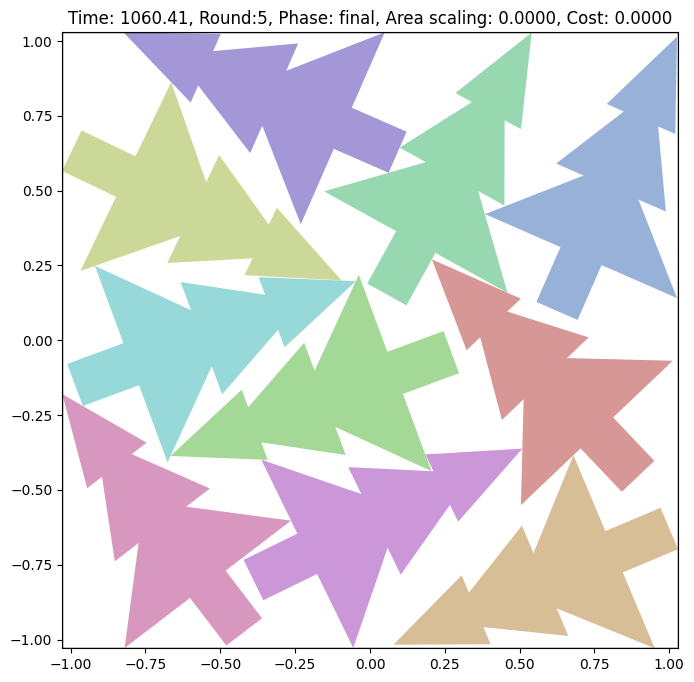

In [3]:
%%time
kgs.profiling=False
runner = MegaDynamics()
runner.n_trees = 10
runner.plot_interval = 10.
runner.n_ensembles = 1000
runner.run_simulation()

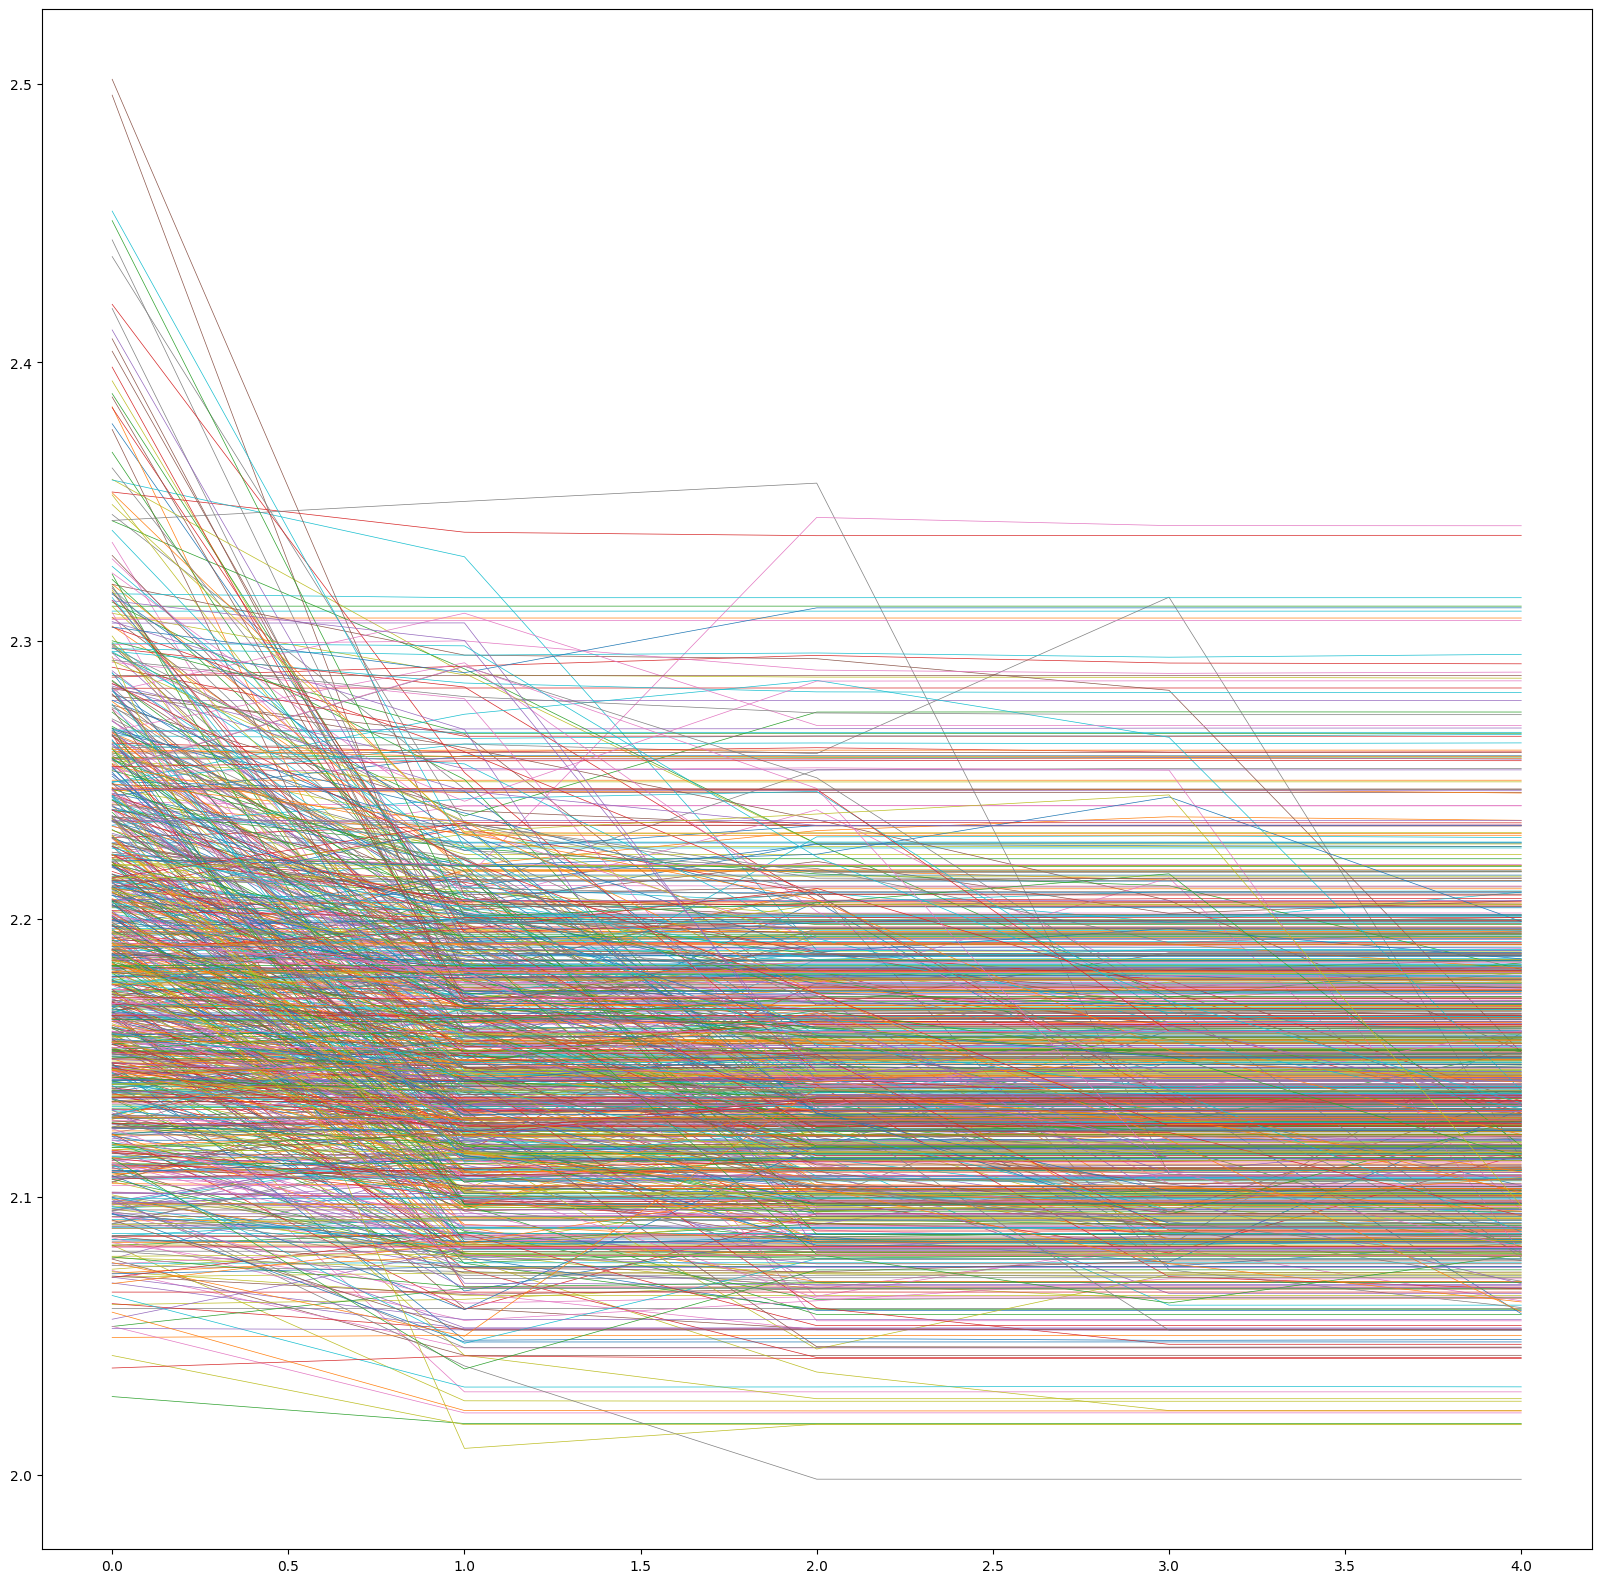

In [7]:
plt.figure(figsize=(20,20))
plt.plot(runner.sizes.T, linewidth=0.5);